In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import jax
import jax.numpy as jnp
import jax.random as random
import time
from pathlib import Path
import sys

# Add parent directory to path
parent_dir = Path.cwd().parent
sys.path.insert(0, str(parent_dir))

import jax_gibbs as gs_jax
import utils

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
# Configuration
T_gibbs = 50000  # Long chain 
T_kde = 50000     # Number of simulations for KDE benchmark

# Test parameters
ks = [1.0, 2.0, 3.0, 5.0]  # Different k values
ms = [10, 20, 50]          # Different m values
mu_true = 2.0              # True location parameter

# Common sampler parameters
base_params = {
    'mu_true': mu_true,
    'prior_mean': 0.0,
    'prior_std': 10.0,
    'proposal_std_mu': 0.9,
    'proposal_std_z': 0.03,
}

print(f"Configuration:")
print(f"  Gibbs chain length: T = {T_gibbs:,}")
print(f"  KDE simulations: {T_kde:,}")
print(f"  Testing k values: {ks}")
print(f"  Testing m values: {ms}")
print(f"  True μ = {mu_true}")


Configuration:
  Gibbs chain length: T = 50,000
  KDE simulations: 50,000
  Testing k values: [1.0, 2.0, 3.0, 5.0]
  Testing m values: [10, 20, 50]
  True μ = 2.0


## Part 1: Focus on k=1 (Cauchy)


In [3]:
# Focus on k=1 (Cauchy case)
k_cauchy = 1.0
m_test = 100

# Set up parameters
params = base_params.copy()
params['k'] = k_cauchy
params['m'] = m_test
params['num_iterations_T'] = T_gibbs

# Generate data
key = random.PRNGKey(42)
key, subkey = random.split(key)
data = random.t(subkey, df=k_cauchy, shape=(m_test,)) + mu_true
mle = utils.get_mle(data, params)

print(f"k = {k_cauchy} (Cauchy), m = {m_test}")
print(f"Generated data: {data}")
print(f"Calculated MLE μ* = {mle:.4f}")
print(f"True μ = {mu_true:.4f}")


k = 1.0 (Cauchy), m = 100
Generated data: [-2.25919339e+00 -2.84229171e-02  2.30742177e+00  3.59600687e-01
  1.92624690e+00 -1.05531304e+01  5.60238592e+00  2.96940796e-01
 -2.59354836e+00  2.42935263e+00  9.29453975e-01  3.32984763e+00
  1.27689337e+00  8.55287487e+00  1.94661019e-03  4.48162878e-01
  1.76162236e+00  4.39604217e+00  2.01117711e+00  4.27076075e+00
  2.71600772e+00  2.14838349e+00  3.01937975e+00  2.55658290e+00
  8.32554551e+00  3.81411892e+00  8.11370782e-01 -1.71359191e+00
  2.32816188e+00  1.31207002e+00  1.12543423e+00  2.73006442e+00
  4.87648864e+00 -9.28388088e-01  3.38096899e+00 -5.48209958e+00
  2.33731133e-02  3.21222429e+00  2.06758450e+00  1.52274643e+00
  3.11779955e+00  2.05454720e+00  2.51569852e+00  1.79465105e+00
  2.12825947e+00  1.37056623e+00  8.72910858e-01  2.44419114e+00
  2.81352823e+00 -5.15275951e-01  3.39214627e+00 -3.41642795e+00
 -6.80544000e-01 -1.04251388e+00  6.28083113e-01  8.23347306e+00
 -1.53536863e+00  7.52882421e+00  3.74019335e+00

In [4]:
# Run JAX Gibbs sampler
print("Running JAX Gibbs sampler...")
t0 = time.time()
key_gibbs = random.PRNGKey(123)
gibbs_results = gs_jax.run_gibbs_sampler_mle_jax(key_gibbs, mle, params)
time_gibbs = time.time() - t0

mu_chain_gibbs = np.array(gibbs_results['mu_chain'])
print(f"\nGibbs sampler completed in {time_gibbs:.2f} seconds")
print(f"Mu acceptance rate: {gibbs_results['mu_acceptance_rate']:.4f}")
print(f"Z_i acceptance rate: {gibbs_results['z_i_acceptance_rate']:.4f}")


Running JAX Gibbs sampler...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [04:53<00:00, 170.37it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.2009
Z_i Acceptance Rate: 0.7782

Gibbs sampler completed in 293.80 seconds
Mu acceptance rate: 0.2009
Z_i acceptance rate: 0.7782


In [27]:
# Compute KDE-based posterior
print("Computing KDE-based posterior...")
t0 = time.time()
params['kde_bw_method'] = .001
kde_posterior_pdf = utils.get_normalized_posterior_mle_pdf(mle, params, num_simulations=T_kde)
time_kde = time.time() - t0

print(f"KDE computation completed in {time_kde:.2f} seconds")


Computing KDE-based posterior...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = 0.001
KDE computation completed in 13.06 seconds


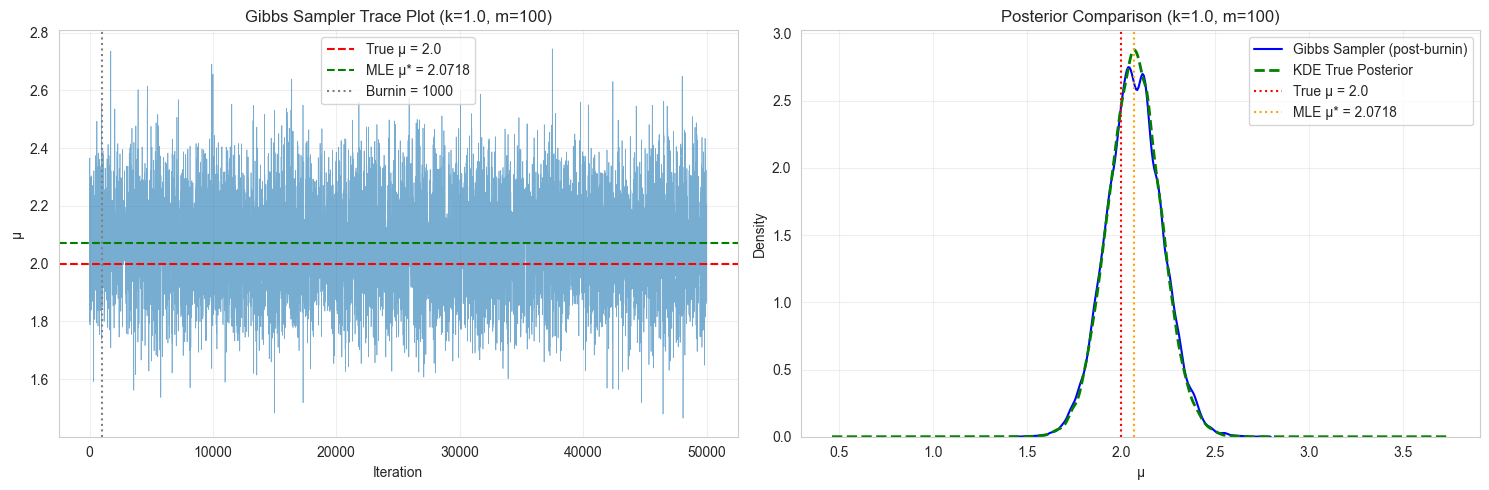


Gibbs Sampler Statistics (post-burnin):
  Mean: 2.0719
  Std:  0.1474
  Variance: 0.0217


In [28]:
# Compare Gibbs sampler with KDE
burnin = 1000
mu_chain_post_burnin = mu_chain_gibbs[burnin:]

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Trace plot
axes[0].plot(mu_chain_gibbs, alpha=0.6, linewidth=0.5)
axes[0].axhline(mu_true, color='red', linestyle='--', label=f'True μ = {mu_true}')
axes[0].axhline(mle, color='green', linestyle='--', label=f'MLE μ* = {mle:.4f}')
axes[0].axvline(burnin, color='gray', linestyle=':', label=f'Burnin = {burnin}')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('μ')
axes[0].set_title(f'Gibbs Sampler Trace Plot (k={k_cauchy}, m={m_test})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Density comparison
mu_grid = np.linspace(mu_chain_post_burnin.min() - 1, mu_chain_post_burnin.max() + 1, 1000)
kde_pdf_values = kde_posterior_pdf(mu_grid)

sns.kdeplot(mu_chain_post_burnin, label='Gibbs Sampler (post-burnin)', ax=axes[1], color='blue')
axes[1].plot(mu_grid, kde_pdf_values, label='KDE True Posterior', color='green', linestyle='--', linewidth=2)
axes[1].axvline(mu_true, color='red', linestyle=':', label=f'True μ = {mu_true}')
axes[1].axvline(mle, color='orange', linestyle=':', label=f'MLE μ* = {mle:.4f}')
axes[1].set_xlabel('μ')
axes[1].set_ylabel('Density')
axes[1].set_title(f'Posterior Comparison (k={k_cauchy}, m={m_test})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'gibbs_vs_kde_k{int(k_cauchy)}_m{m_test}.pdf', dpi=300)
plt.show()

# Print statistics
print(f"\nGibbs Sampler Statistics (post-burnin):")
print(f"  Mean: {mu_chain_post_burnin.mean():.4f}")
print(f"  Std:  {mu_chain_post_burnin.std():.4f}")
print(f"  Variance: {mu_chain_post_burnin.var():.4f}")


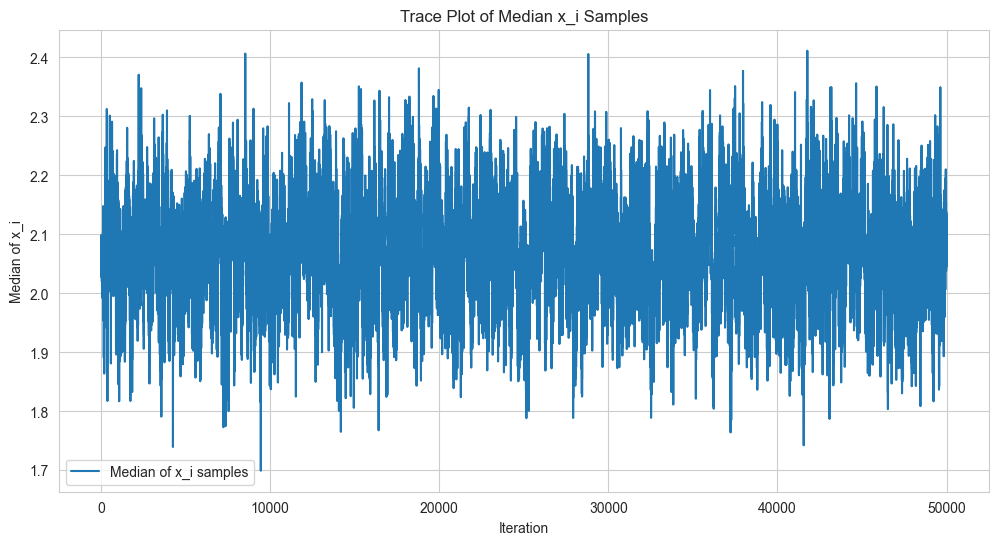

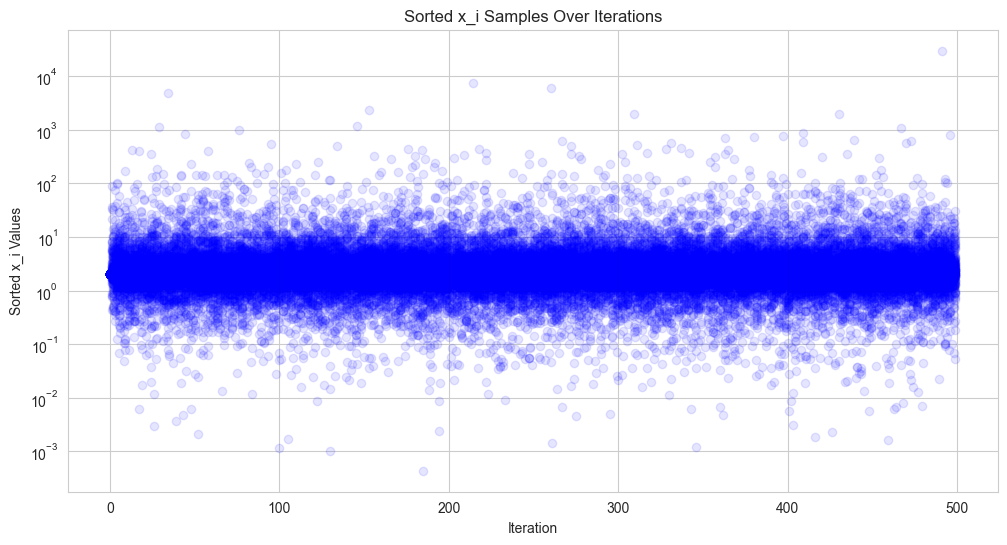


Gibbs Sampler Statistics (post-burnin):


In [29]:

a,b = 48000, 53000
a,b = 0, T_gibbs
med_x = [np.median(x) for x in gibbs_results['x_chain'][a:b]]
sorted_x = [np.sort(x) for x in gibbs_results['x_chain'][a:b]]
plt.plot(med_x, label='Median of x_i samples')
plt.title('Trace Plot of Median x_i Samples')
plt.xlabel('Iteration')
plt.ylabel('Median of x_i')
plt.legend()
plt.show()

for i, x in enumerate(sorted_x[::100]):
    plt.scatter([i]*len(x), x, color='blue', alpha=0.1)
plt.yscale("log")
plt.title('Sorted x_i Samples Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Sorted x_i Values')
plt.show() 
print(f"\nGibbs Sampler Statistics (post-burnin):")


In [30]:
min_x = [np.min(x) for x in gibbs_results['x_chain'][a:b]]
max_x = [np.max(x) for x in gibbs_results['x_chain'][a:b]]
i_min = np.argmin(min_x) + a


In [31]:
x_before_kernel = gibbs_results["x_chain"][i_min - 1]
x_after_kernel = gibbs_results["x_chain"][i_min]


In [13]:
import scipy.stats as stats
1/(1-stats.cauchy.cdf(2e6))

6283185.310710803

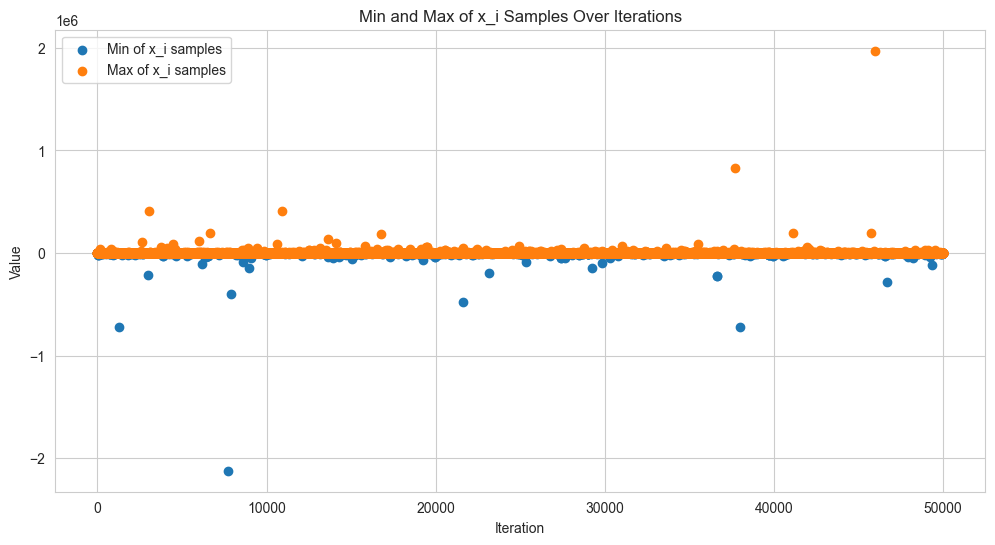

In [32]:
min_x = [np.min(x) for x in gibbs_results['x_chain'][a:b]]
max_x = [np.max(x) for x in gibbs_results['x_chain'][a:b]]

plt.scatter(range(a, b), min_x, label='Min of x_i samples')
plt.scatter(range(a, b), max_x, label='Max of x_i samples')
# plt.yscale("log")
plt.title('Min and Max of x_i Samples Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
plt.show()

## Part 2: Empirical Variance Analysis for Different k and m

e empirical variance of the posterior given the MLE for different k and m values.


In [36]:
# Store results for variance analysis
results = {
    'k': [],
    'm': [],
    'gibbs_variance': [],
    'kde_variance': [],
    'gibbs_mean': [],
    'kde_mean': [],
    'mle': [],
    'time_gibbs': [],
    'time_kde': []
}

# Run analysis for different k and m combinations
key = random.PRNGKey(0)
for k in ks:
    for m in ms:
        print(f"\n{'='*60}")
        print(f"Processing k={k}, m={m}")
        print(f"{'='*60}")
        
        # Set up parameters
        params = base_params.copy()
        params['k'] = k
        params['m'] = m
        params['num_iterations_T'] = T_gibbs
        
        # Generate data
        key, subkey = random.split(key)
        data = random.t(subkey, df=k, shape=(m,)) + mu_true
        mle = utils.get_mle(data, params)
        
        # Run Gibbs sampler
        print(f"  Running Gibbs sampler (T={T_gibbs:,})...")
        key, key_gibbs = random.split(key)
        t0 = time.time()
        gibbs_results = gs_jax.run_gibbs_sampler_mle_jax(key_gibbs, mle, params)
        time_gibbs = time.time() - t0
        
        mu_chain_gibbs = np.array(gibbs_results['mu_chain'])
        burnin = 1000
        mu_chain_post_burnin = mu_chain_gibbs[burnin:]
        
        # Compute KDE posterior
        print(f"  Computing KDE posterior ({T_kde:,} simulations)...")
        t0 = time.time()
        kde_posterior_pdf = utils.get_normalized_posterior_mle_pdf(mle, params, num_simulations=T_kde)
        time_kde = time.time() - t0
        
        # Compute variance using numerical integration for KDE
        mu_grid = np.linspace(mu_chain_post_burnin.min() - 2, mu_chain_post_burnin.max() + 2, 2000)
        kde_pdf_values = kde_posterior_pdf(mu_grid)
        
        # Normalize KDE pdf (in case of numerical issues)
        kde_pdf_values = kde_pdf_values / np.trapz(kde_pdf_values, mu_grid)
        
        # Compute KDE mean and variance
        kde_mean = np.trapz(mu_grid * kde_pdf_values, mu_grid)
        kde_variance = np.trapz((mu_grid - kde_mean)**2 * kde_pdf_values, mu_grid)
        
        # Store results
        results['k'].append(k)
        results['m'].append(m)
        results['gibbs_variance'].append(mu_chain_post_burnin.var())
        results['kde_variance'].append(kde_variance)
        results['gibbs_mean'].append(mu_chain_post_burnin.mean())
        results['kde_mean'].append(kde_mean)
        results['mle'].append(mle)
        results['time_gibbs'].append(time_gibbs)
        results['time_kde'].append(time_kde)
        
        print(f"  Gibbs variance: {mu_chain_post_burnin.var():.6f}")
        print(f"  KDE variance:   {kde_variance:.6f}")
        print(f"  Variance ratio (Gibbs/KDE): {mu_chain_post_burnin.var()/kde_variance:.4f}")
        print(f"  Time - Gibbs: {time_gibbs:.2f}s, KDE: {time_kde:.2f}s")



Processing k=1.0, m=10
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler:  30%|██▉       | 14927/50000 [00:44<01:44, 336.82it/s]


KeyboardInterrupt: 

In [ ]:
# Create summary table
import pandas as pd

df_results = pd.DataFrame(results)
print("\n" + "="*80)
print("SUMMARY: Empirical Variance Analysis")
print("="*80)
print(df_results.to_string(index=False))



SUMMARY: Empirical Variance Analysis
  k  m  gibbs_variance  kde_variance  gibbs_mean  kde_mean      mle  time_gibbs  time_kde
1.0 10      183.672305      0.792591   -5.335426  2.048510 2.063652   91.560796  5.642770
1.0 20        0.163241      0.663517    1.937008  1.935557 1.946915  118.716736  4.911421
1.0 50        0.045148      0.531414    1.582568  1.578870 1.586572  176.309269  3.733975
2.0 10        0.344733      0.191657    1.866785  1.844735 1.850694   92.987643  6.403237
2.0 20        0.094790      0.089303    1.911150  1.911642 1.913057  116.901550  6.480371
2.0 50        0.034188      0.034216    2.153714  2.153209 2.153558  197.614187  9.302732
3.0 10        0.175397      0.162276    2.046869  2.045660 2.050711   95.903759  6.971778
3.0 20        0.079989      0.078434    2.005202  2.002070 2.005416  121.199083  7.171164
3.0 50        0.031153      0.031136    1.984323  1.986172 1.987728  194.667897  6.695438
5.0 10        0.143510      0.139956    1.897567  1.902827 1.9

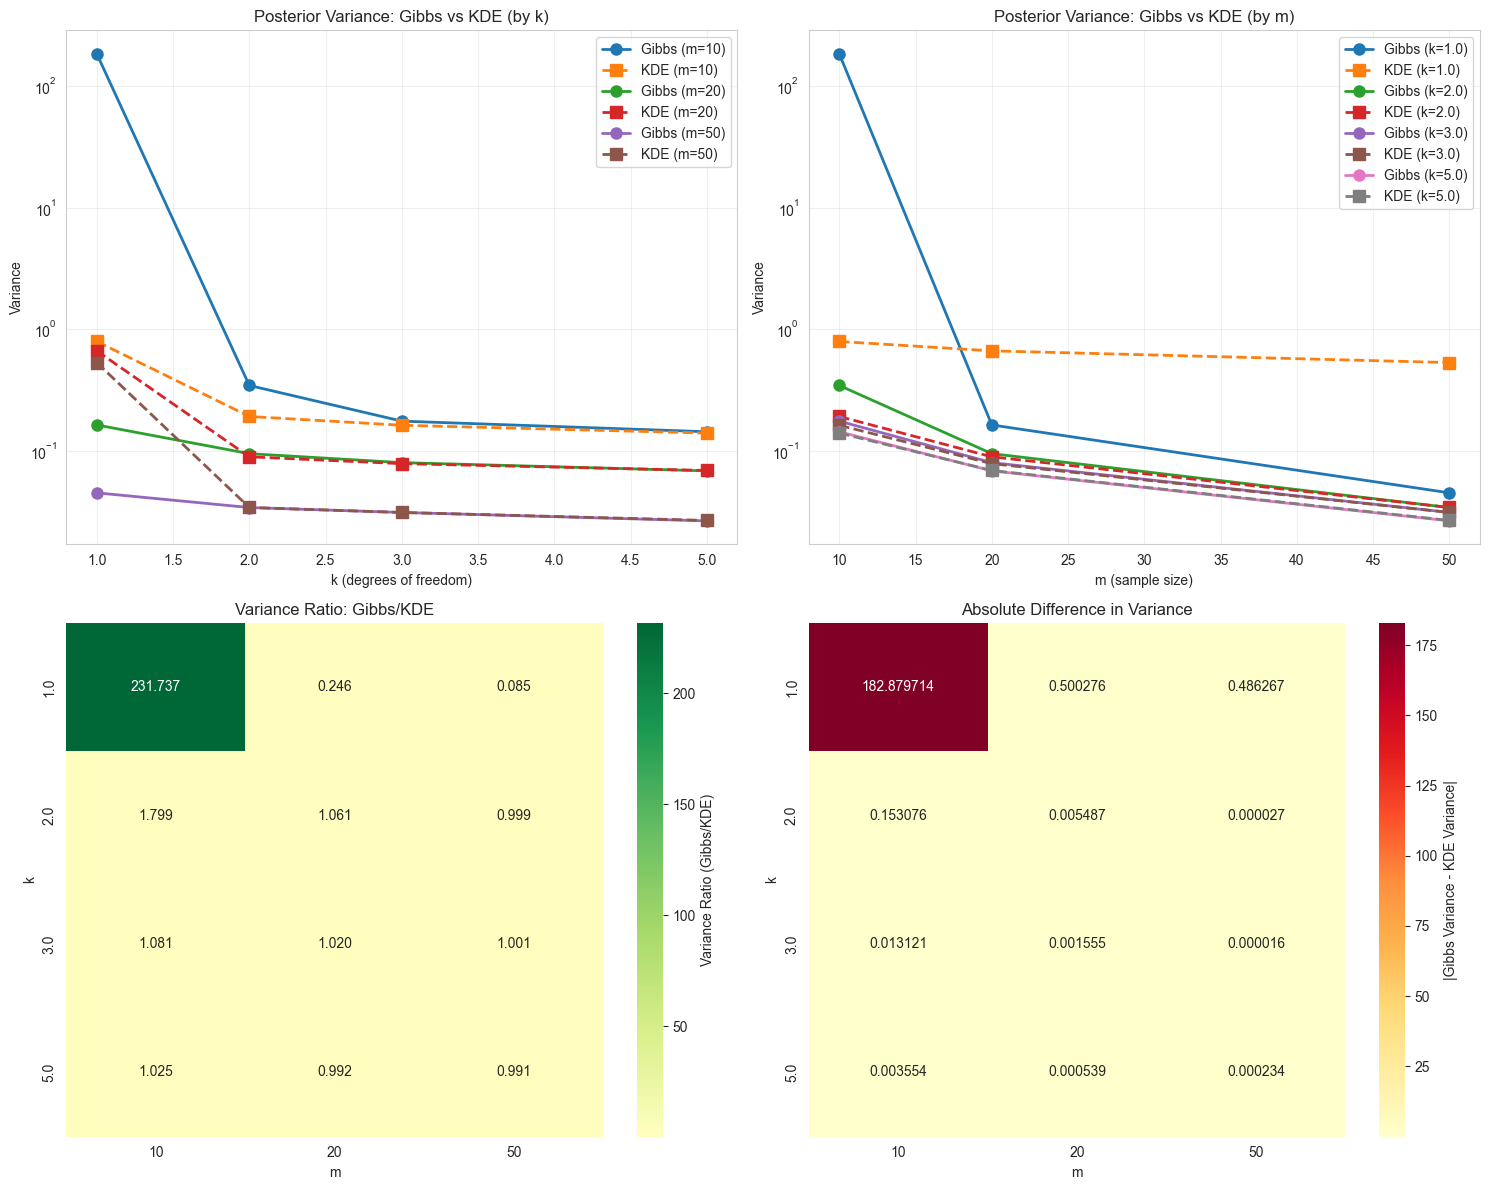

In [ ]:
# Visualize variance comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Variance comparison by k
for m in ms:
    mask = df_results['m'] == m
    axes[0, 0].plot(df_results[mask]['k'], df_results[mask]['gibbs_variance'], 
                    'o-', label=f'Gibbs (m={m})', linewidth=2, markersize=8)
    axes[0, 0].plot(df_results[mask]['k'], df_results[mask]['kde_variance'], 
                    's--', label=f'KDE (m={m})', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('k (degrees of freedom)')
axes[0, 0].set_ylabel('Variance')
axes[0, 0].set_title('Posterior Variance: Gibbs vs KDE (by k)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

# Variance comparison by m
for k in ks:
    mask = df_results['k'] == k
    axes[0, 1].plot(df_results[mask]['m'], df_results[mask]['gibbs_variance'], 
                    'o-', label=f'Gibbs (k={k})', linewidth=2, markersize=8)
    axes[0, 1].plot(df_results[mask]['m'], df_results[mask]['kde_variance'], 
                    's--', label=f'KDE (k={k})', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('m (sample size)')
axes[0, 1].set_ylabel('Variance')
axes[0, 1].set_title('Posterior Variance: Gibbs vs KDE (by m)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_yscale('log')

# Variance ratio (Gibbs/KDE)
df_results['variance_ratio'] = df_results['gibbs_variance'] / df_results['kde_variance']
pivot_ratio = df_results.pivot(index='k', columns='m', values='variance_ratio')
sns.heatmap(pivot_ratio, annot=True, fmt='.3f', cmap='RdYlGn', center=1.0, 
            ax=axes[1, 0], cbar_kws={'label': 'Variance Ratio (Gibbs/KDE)'})
axes[1, 0].set_title('Variance Ratio: Gibbs/KDE')
axes[1, 0].set_xlabel('m')
axes[1, 0].set_ylabel('k')

# Absolute difference in variance
df_results['variance_diff'] = np.abs(df_results['gibbs_variance'] - df_results['kde_variance'])
pivot_diff = df_results.pivot(index='k', columns='m', values='variance_diff')
sns.heatmap(pivot_diff, annot=True, fmt='.6f', cmap='YlOrRd', 
            ax=axes[1, 1], cbar_kws={'label': '|Gibbs Variance - KDE Variance|'})
axes[1, 1].set_title('Absolute Difference in Variance')
axes[1, 1].set_xlabel('m')
axes[1, 1].set_ylabel('k')

plt.tight_layout()
plt.show()



DETAILED ANALYSIS: k=1 (Cauchy) Case
 m  gibbs_variance  kde_variance  variance_ratio  variance_diff
10      183.672305      0.792591      231.736510     182.879714
20        0.163241      0.663517        0.246024       0.500276
50        0.045148      0.531414        0.084957       0.486267


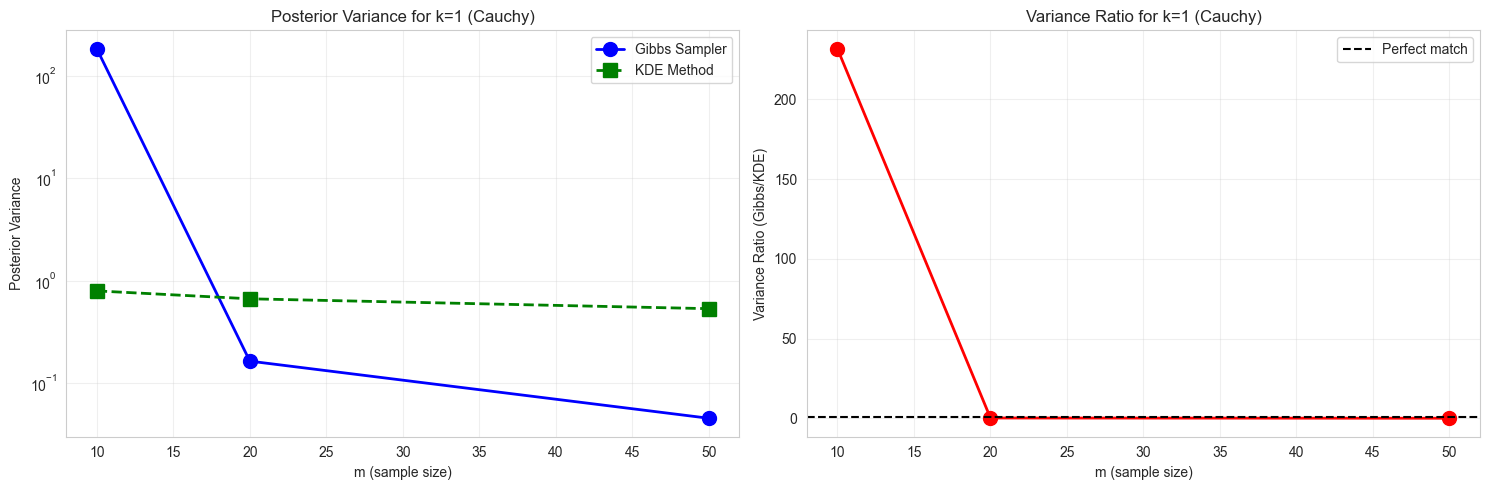

In [ ]:
# Focus on k=1 (Cauchy) case - detailed analysis
print("\n" + "="*80)
print("DETAILED ANALYSIS: k=1 (Cauchy) Case")
print("="*80)

cauchy_results = df_results[df_results['k'] == 1.0].copy()
print(cauchy_results[['m', 'gibbs_variance', 'kde_variance', 'variance_ratio', 'variance_diff']].to_string(index=False))

# Plot for k=1 across different m
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

mask = df_results['k'] == 1.0
axes[0].plot(df_results[mask]['m'], df_results[mask]['gibbs_variance'], 
             'o-', label='Gibbs Sampler', linewidth=2, markersize=10, color='blue')
axes[0].plot(df_results[mask]['m'], df_results[mask]['kde_variance'], 
             's--', label='KDE Method', linewidth=2, markersize=10, color='green')
axes[0].set_xlabel('m (sample size)')
axes[0].set_ylabel('Posterior Variance')
axes[0].set_title('Posterior Variance for k=1 (Cauchy)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

axes[1].plot(df_results[mask]['m'], df_results[mask]['variance_ratio'], 
             'o-', linewidth=2, markersize=10, color='red')
axes[1].axhline(1.0, color='black', linestyle='--', label='Perfect match')
axes[1].set_xlabel('m (sample size)')
axes[1].set_ylabel('Variance Ratio (Gibbs/KDE)')
axes[1].set_title('Variance Ratio for k=1 (Cauchy)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Part 3: Additional Diagnostics for k=1 Case

Let's check the gradient likelihood checks and other diagnostics to ensure the sampler is working correctly.


In [ ]:
gibbs_results_cauchy=gibbs_results

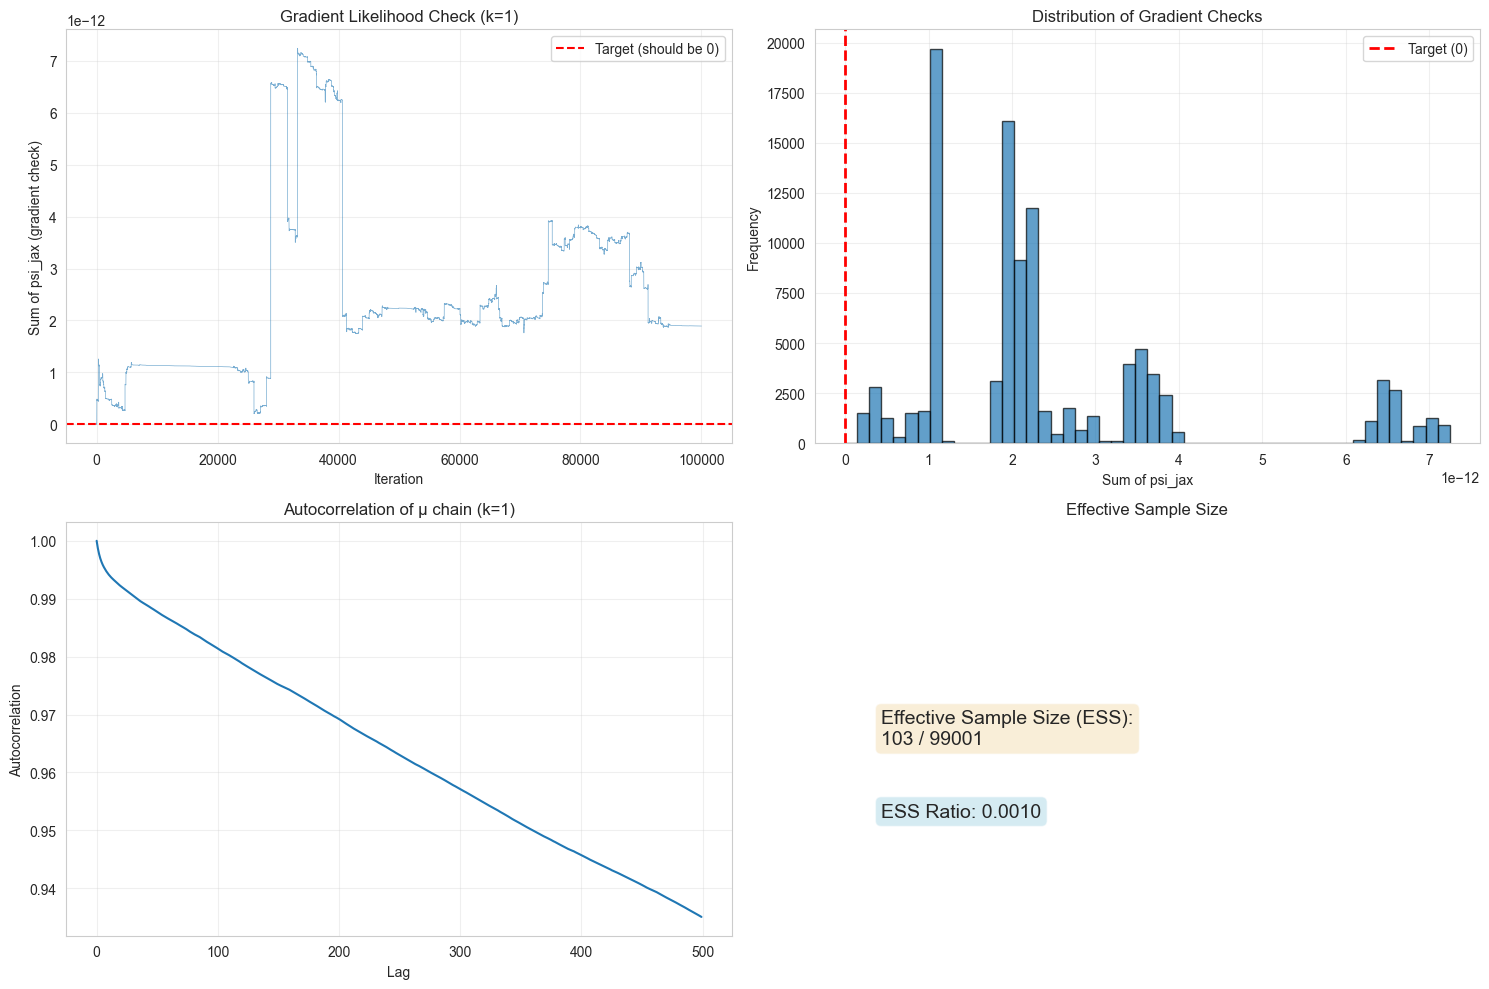


Diagnostics for k=1, m=10:
  Mean gradient check: 0.000000
  Std gradient check: 0.000000
  Max |gradient check|: 0.000000
  Effective Sample Size: 103 / 99001 (0.10%)


In [ ]:
# Re-run k=1 case for diagnostics (if not already stored)
if 'gibbs_results_cauchy' not in locals():
    k_cauchy = 1.0
    m_test = 10
    params = base_params.copy()
    params['k'] = k_cauchy
    params['m'] = m_test
    params['num_iterations_T'] = T_gibbs
    
    key = random.PRNGKey(42)
    key, subkey = random.split(key)
    data = random.t(subkey, df=k_cauchy, shape=(m_test,)) + mu_true
    mle = utils.get_mle(data, params)
    
    key, key_gibbs = random.split(key)
    gibbs_results_cauchy = gs_jax.run_gibbs_sampler_mle_jax(key_gibbs, mle, params)

# Plot diagnostics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gradient likelihood checks (should be close to 0)
grad_checks = np.array(gibbs_results_cauchy['grad_likelihood_checks'])
axes[0, 0].plot(grad_checks, alpha=0.6, linewidth=0.5)
axes[0, 0].axhline(0, color='red', linestyle='--', label='Target (should be 0)')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Sum of psi_jax (gradient check)')
axes[0, 0].set_title('Gradient Likelihood Check (k=1)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Histogram of gradient checks
axes[0, 1].hist(grad_checks, bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Target (0)')
axes[0, 1].set_xlabel('Sum of psi_jax')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Gradient Checks')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Autocorrelation
from scipy import signal
mu_chain = np.array(gibbs_results_cauchy['mu_chain'])
burnin = 1000
mu_chain_post = mu_chain[burnin:]
autocorr = np.correlate(mu_chain_post - mu_chain_post.mean(), 
                        mu_chain_post - mu_chain_post.mean(), mode='full')
autocorr = autocorr[len(autocorr)//2:]
autocorr = autocorr / autocorr[0]
max_lag = min(500, len(autocorr))
axes[1, 0].plot(autocorr[:max_lag])
axes[1, 0].set_xlabel('Lag')
axes[1, 0].set_ylabel('Autocorrelation')
axes[1, 0].set_title('Autocorrelation of μ chain (k=1)')
axes[1, 0].grid(True, alpha=0.3)

# Effective sample size (rough estimate)
# ESS ≈ N / (1 + 2*sum(autocorr))
integrated_autocorr = 1 + 2 * np.sum(autocorr[1:max_lag])
ess = len(mu_chain_post) / integrated_autocorr
axes[1, 1].text(0.1, 0.5, f'Effective Sample Size (ESS):\n{ess:.0f} / {len(mu_chain_post)}', 
                fontsize=14, verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 1].text(0.1, 0.3, f'ESS Ratio: {ess/len(mu_chain_post):.4f}', 
                fontsize=14, verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
axes[1, 1].set_xlim(0, 1)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].axis('off')
axes[1, 1].set_title('Effective Sample Size')

plt.tight_layout()
plt.show()

print(f"\nDiagnostics for k=1, m=10:")
print(f"  Mean gradient check: {grad_checks.mean():.6f}")
print(f"  Std gradient check: {grad_checks.std():.6f}")
print(f"  Max |gradient check|: {np.abs(grad_checks).max():.6f}")
print(f"  Effective Sample Size: {ess:.0f} / {len(mu_chain_post)} ({ess/len(mu_chain_post)*100:.2f}%)")


In [6]:
from jax_gibbs import psi_inverse_jax, log_psi_prime_abs_jax, psi_jax, fy_logpdf_jax, update_z_one


def safe_choice_2(key, candidates, log_w):
    log_w = jnp.where(jnp.isfinite(log_w), log_w, -jnp.inf)
    logZ = logsumexp(log_w)

    def fallback(_):
        return candidates[0]

    def sample(_):
        probs = jnp.exp(log_w - logZ)
        idx = random.choice(key, 2, p=probs)
        return candidates[idx]

    return jax.lax.cond(jnp.isfinite(logZ), sample, fallback, operand=None)
    
z = .0009
k = 1
mu_current = 0.0
mu_star = 0.0

y1, y2 = psi_inverse_jax(z, 1)
y_candidates = jnp.array([y1, y2])  

log_w = fy_logpdf_jax(y_candidates, mu_current, mu_star, k) - log_psi_prime_abs_jax(y_candidates, k)
log_w

Array([-1.14472827, -1.14472827], dtype=float64)

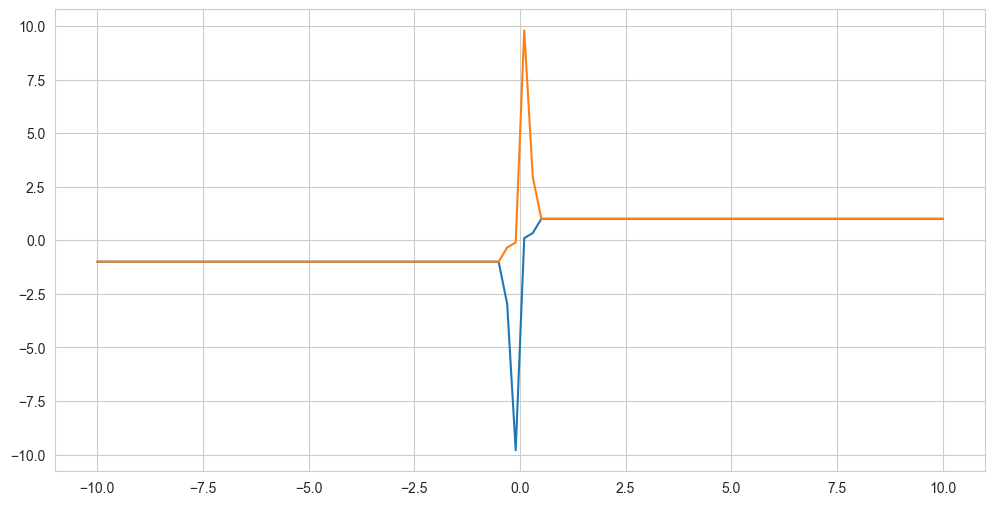

In [16]:

yplus = []
yminus = []

zs = jnp.linspace(-10, 10, 100)
for z in zs:
    y1, y2 = psi_inverse_jax(z, 1)
    yplus.append(y1)
    yminus.append(y2)
    
plt.plot(zs,yplus, label='y_plus')
plt.plot(zs, yminus, label='y_minus')
plt.show()
    